In [1]:
# import os
# os.environ['MKL_NUM_THREADS'] = '12'

In [2]:
### For automatically reloading import modules... allows you to run changes to code in jupyter without having to reload
%load_ext autoreload
%autoreload 2

In [3]:
# import zipfile
# import h5py
import os
import sys
import time
import timeit
import pickle
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity, TanimotoSimilarity

IPythonConsole.drawOptions.addAtomIndices = True

from photocatalysis.learners_treesearch import get_population_completed
from photocatalysis.deeplearning.helpers import get_charset, smiles_to_onehot, one_hot_to_smile, plot_model_performance, verify_smile, reconstruction_accuracy,prior_validity_accuracy

import selfies as sf
from photocatalysis.deeplearning.helpers import get_charset_selfies, selfies_to_onehot

from photocatalysis.deeplearning.models import VAE, train_epoch

In [50]:
from IPython.display import display as dp

In [4]:
from IPython import display
from IPython.display import IFrame

In [5]:
from rdkit import RDLogger

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [6]:
import torch
import torch.optim as optim
import torchinfo

from torch import nn as nn
import torch.nn.functional as F
torch.manual_seed(42)

print(f'CUDA GPU Available: {torch.cuda.is_available()}')

CUDA GPU Available: False


In [7]:
df = pd.read_json('/home/btpq/bt308495/Thesis/frames/DF_COMPLETE.json', orient='split')
df = get_population_completed(df)

SELFIES

In [ ]:
# All molecules encode and decode successfully
molecule_selfies = [sf.encoder(s) for s in df.molecule_smiles]

In [ ]:
input_size = 60
sos_token = "X"
eos_token = "[nop]"

char_list, max_selfie_len = get_charset_selfies(molecule_selfies, sos_token=sos_token, eos_token=eos_token)
X = selfies_to_onehot(molecule_selfies, char_list, max_selfie_len=input_size)
y = df.utility_function.values.astype(np.float32)[:, None]

SMILES

In [8]:
input_size = 80
sos_token = 'X'
eos_token = ' '

char_list, max_smi_len = get_charset(df.molecule_smiles, sos_token=sos_token, eos_token=eos_token)
X = smiles_to_onehot(df.molecule_smiles, char_list, input_size)
y = df.utility_function.values.astype(np.float32)[:, None]

In [9]:
# 80/5/15 Train/Val/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.75, shuffle=False)

In [10]:
batch_size = 250

# Convert to Torch Tensor
X_tensor = torch.from_numpy(X)
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)

X_valid_tensor = torch.from_numpy(X_valid)
y_valid_tensor = torch.from_numpy(y_valid)

X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

# Create Dataset/Dataloader for model training
data_train = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
data_valid = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)
data_test = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=250, shuffle=True)
valid_loader = torch.utils.data.DataLoader(data_valid, batch_size=250, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=250, shuffle=True)

# D = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor[:250], y_train_tensor[:250]), batch_size=250, shuffle=True)

In [11]:
goindex = np.where(char_list == 'X')[0][0]
gotoken = torch.FloatTensor(len(char_list)).zero_()
gotoken[goindex] = 1

## Load Model

In [425]:
def load_model_from_params(params_file, model_training_file, model_weights_file, device='cpu', assert_prob_sample=True):
    # Load Model definition parameters
    with open(params_file, 'rb') as f:
        params = pickle.load(f)

    # Load Training Losses
    with open(model_training_file, 'rb') as f:
        tls, vls = pickle.load(f)

    if assert_prob_sample: params['probabilistic_sampling'] = True
    
    MODEL = VAE(**params).to(device)
    MODEL.load_state_dict(torch.load(model_weights_file, map_location=torch.device(device)))
    MODEL.eval()

    return MODEL, tls, vls

In [426]:
def encode_latent(X_tensor, MODEL):
    with torch.no_grad():
        X = deepcopy(X_tensor)
        X = X.to(device)

        mu_z, logvar_z = MODEL.encode(X)
        z = MODEL.reparameterize(mu_z, logvar_z)

    return z

In [427]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
params_file = '/home/btpq/bt308495/Thesis/photocatalysis/workspace/train_teacher_prop/VAE_model_params.pckl'
training_file = '/home/btpq/bt308495/Thesis/photocatalysis/workspace/train_teacher_prop/VAE_losses_epoch60.pckl'
weights_file = '/home/btpq/bt308495/Thesis/photocatalysis/workspace/train_teacher_prop/VAE_model_params_epoch60.pt'

model, tls, vls = load_model_from_params(params_file, training_file, weights_file, device=device)

In [228]:
# tls, vls = plot_model_performance(tls, vls, name='k')

----

Generative models are useful for generating novel molecules.... but they're internal representations are also very useful!

# Problem

A discrete pre-defined chemical space makes property optimization efforts difficult...

1. Molecular representations are discrete (a smile string)
2. Searching a space for high utility molecules is not possible with gradient-based methods (there is no concept of dU/dsmile)

A continuous representation would be awesome!

1. We wouldn't need to enumerate the space before hand, with mutation rules. New compounds can be generated by simply modifying a particular representation.
2. If we have another model that maps the continuous representation to utility, then we could employ gradient based methods to locate high-performing molecules.

# Variational Autoencoders

### Autoencoders

Non-linear dimensionality reduction (non-linear version of SVD/PCA).

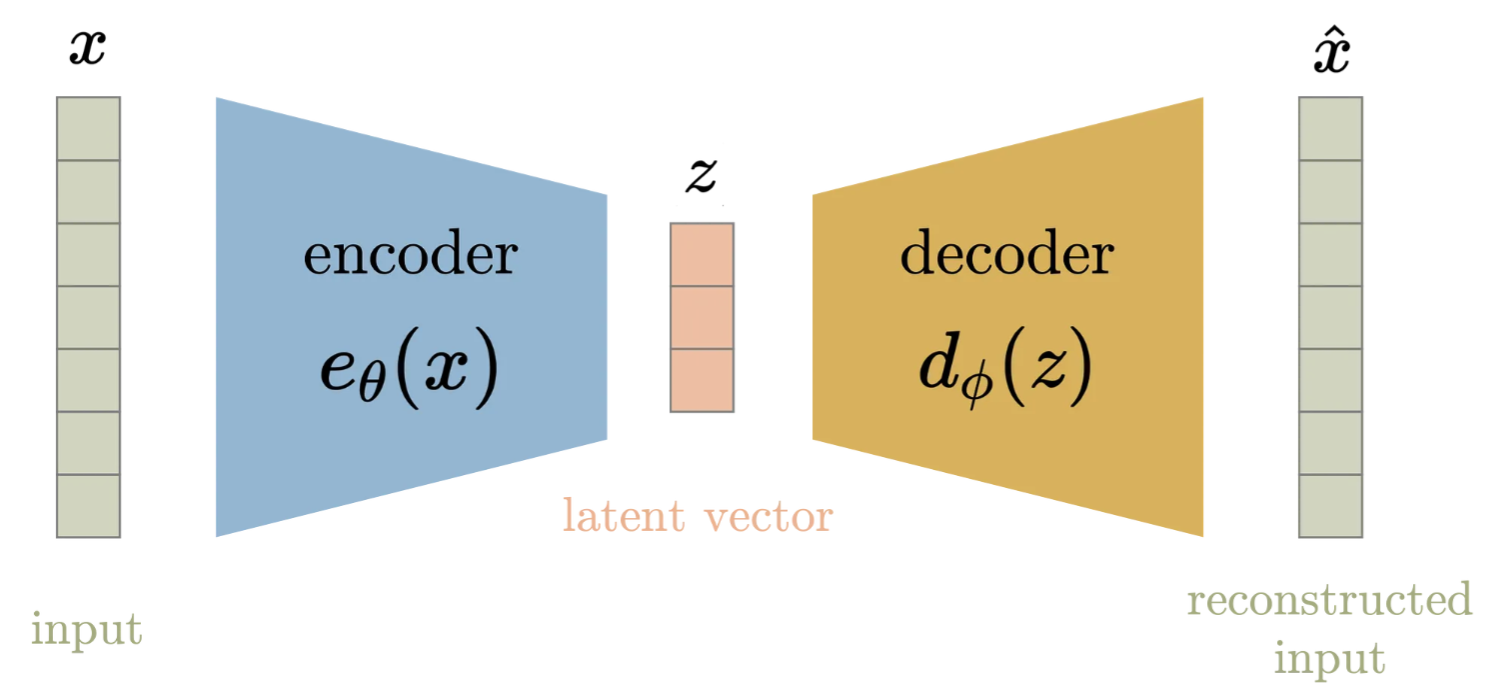

In [428]:
display.Image('ae.PNG')

#### Reconstruction Error

Finger prints are not invertable, so I went with smile strings... although there are other posibilities!

In [429]:
# Alphabet
char_list

array([' ', 'X', 'c', '1', '(', '-', '2', ')', 'C', '=', '#', 'n', 'N',
       'O', 'o', '3', '4', 's', 'S', '[', 'H', ']'], dtype='<U1')

In [430]:
# onehot encoding
df.molecule_smiles.iloc[0], X[0].shape

('c1ccccc1', (80, 22))

In [431]:
X[0]

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

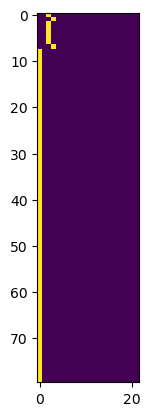

In [432]:
plt.imshow(X[0])

### Model Architecture

Feature Extraction: CNN's and FF NN's for the encoder

In [433]:
IFrame(src='https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks', width=700, height=600)

Sequencing: RNN's for the decoder (NLP)

Apply the same function for each element of sequential data, with the output being depended
on the result of the previous step. Enables the network to memorize
past events and model data according to previous inputs

In [434]:
torchinfo.summary(model, input_size=(250, 80, 22))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [250, 80, 22]             --
├─Conv1d: 1-1                            [250, 9, 18]              3,609
├─ReLU: 1-2                              [250, 9, 18]              --
├─Conv1d: 1-3                            [250, 9, 14]              414
├─ReLU: 1-4                              [250, 9, 14]              --
├─Conv1d: 1-5                            [250, 10, 8]              640
├─ReLU: 1-6                              [250, 10, 8]              --
├─Linear: 1-7                            [250, 435]                35,235
├─Linear: 1-8                            [250, 292]                127,312
├─Linear: 1-9                            [250, 292]                127,312
├─propertyPredictor: 1-10                [250, 1]                  --
│    └─Linear: 2-1                       [250, 1000]               293,000
│    └─Sequential: 2-2                   --                  

In [439]:
X_tensor.shape, z.shape

(torch.Size([64142, 80, 22]), torch.Size([64142, 292]))

### Latent Space of AE

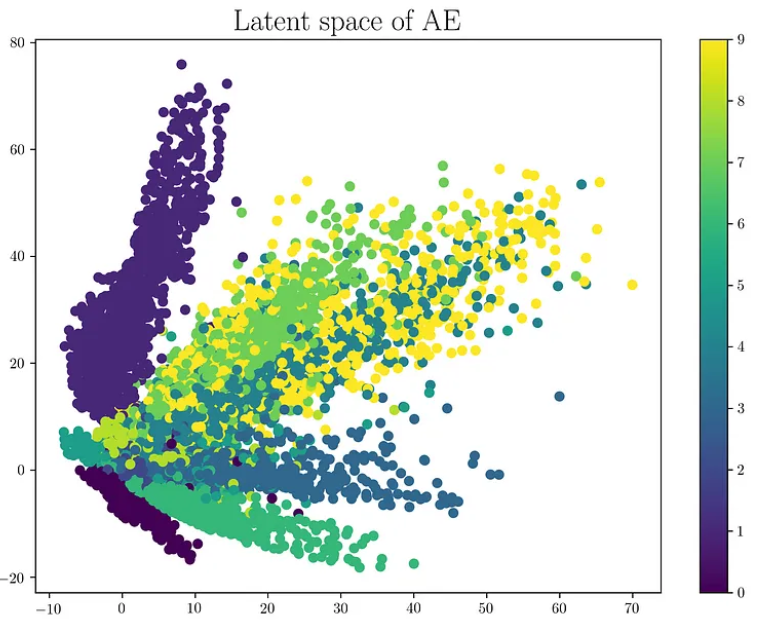

In [435]:
display.Image('latentae.PNG')

The fundamental problem with AE, the latent space may not be so continuous and doesn't allow easy interpolation!

### Variational Autoencoders

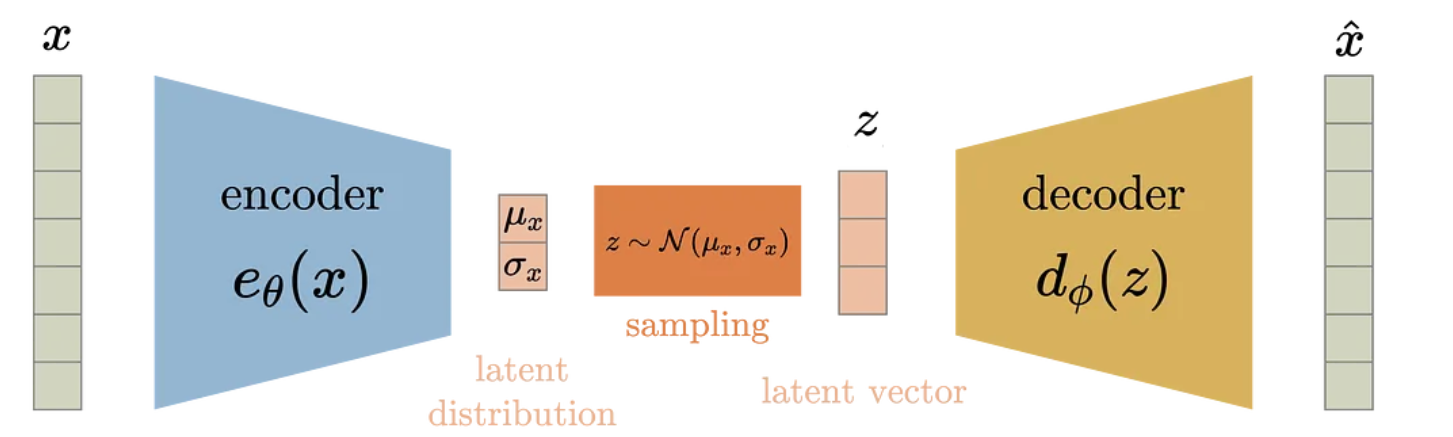

In [440]:
display.Image('vae.PNG')

The intuition is that adding noise to the encoded molecules forces the decoder to learn how to decode a wider variety of latent points and find more robust representations.

Somehow encourage the encoder to distribute all encodings evenly.

So we make the AE probabilistic in the sense that it learns a latent distribution, and we try to enforce that this latent distb. to follows N(0, 1), while still being able to adequately reconstruct the output from the input.

This way, we can smooth out or regularize the latent space such that its ideal for generation purposes.

#### Reconstruction Error + KL-divergence Error

### Latent Space of VAE

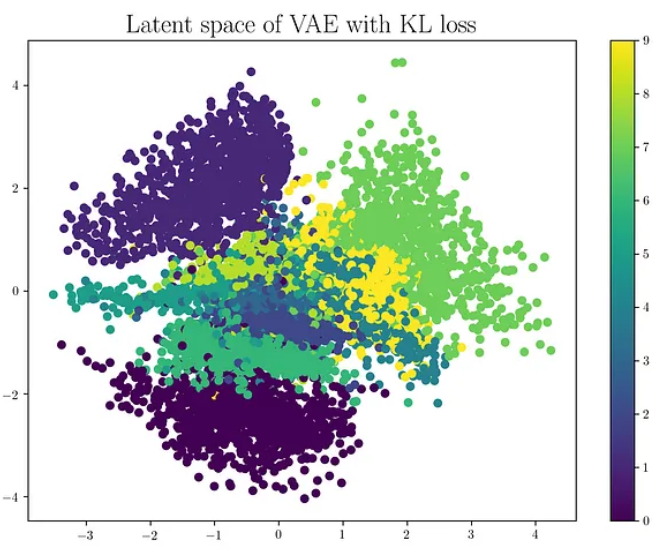

In [441]:
display.Image('latentvae.PNG')

Model has to strike a balance between regularization of the latent space and reconstruction accuracy

# Results

In [442]:
from sklearn.metrics import mean_absolute_error, r2_score

Vanilla VAE

In [443]:
perf.loc[perf.index == 'Vanilla', ['Validation Reconstruction Acc (%)', 'Validation Smile Acc (%)', 'Prior Validity (%)']]

,Validation Reconstruction Acc (%),Validation Smile Acc (%),Prior Validity (%)
Vanilla,87.0,0.02,0.2


While it would be more efficient to limit the autoencoder to generate only valid strings, the postprocessing step of validating the molecule with RDKIT is lightweight and allows for greater flexibility in the autoencoder to learn the architecture of the SMILES.

Teacher Forcing

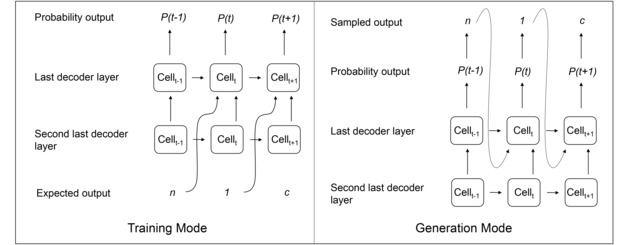

In [444]:
display.Image('denovo.jpg')

In [445]:
perf[['Validation Reconstruction Acc (%)', 'Validation Smile Acc (%)', 'Prior Validity (%)']].iloc[:2]

,Validation Reconstruction Acc (%),Validation Smile Acc (%),Prior Validity (%)
Vanilla,87.0,0.02,0.2
Teacher,88.0,3.30,2.4


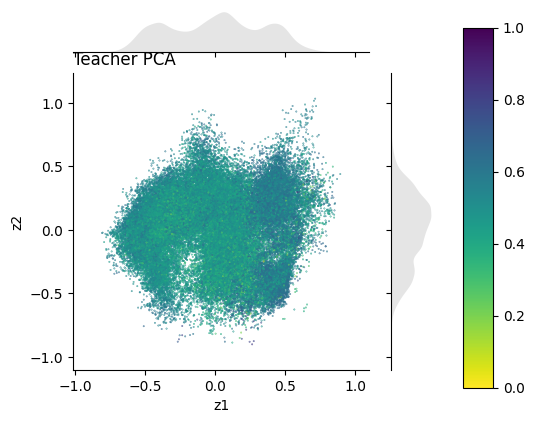

In [446]:
display.Image('teacherpca.png')

Joint Property Prediction

Train a neural network that maps the latent space to the utility (Utility = F(Z)) concurrently...

The idea was that this would help shape or condition the latent space such that its easier to do property prediction/optimization on it in the future...

In [447]:
model.property_predictor

propertyPredictor(
  (linear_in): Linear(in_features=292, out_features=1000, bias=True)
  (linear_mid_i): Linear(in_features=1000, out_features=1000, bias=True)
  (linear_out): Linear(in_features=1000, out_features=1, bias=True)
  (inner_activation): Tanh()
  (mid_module_list): ModuleList(
    (0): Linear(in_features=1000, out_features=1000, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): Tanh()
  )
  (linear_mid): Sequential(
    (0): Linear(in_features=1000, out_features=1000, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): Tanh()
  )
)

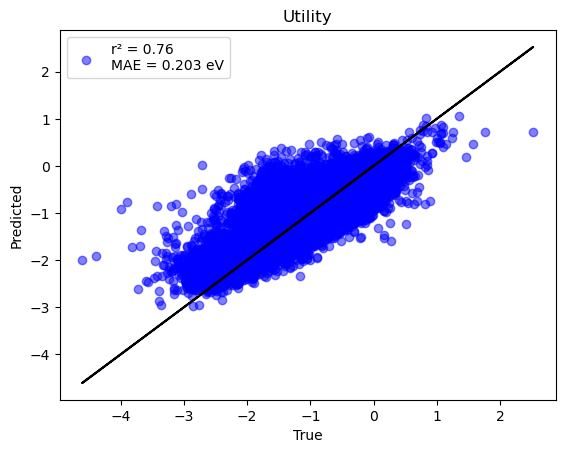

In [448]:
z = encode_latent(X_tensor, model)
ypred = model.property_predictor(z).detach().numpy()

mae_utility = float(mean_absolute_error(y, ypred)) # mae
r2_utility = float(r2_score(y, ypred)) # pearson r2 score

label = f'r\u00b2 = {round(r2_utility, 2)} \nMAE = {round(mae_utility, 3)} eV'
plt.scatter(y, ypred, label=label, color='b', alpha=0.5)
plt.plot(y, y, color='k')

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Utility')
plt.legend()

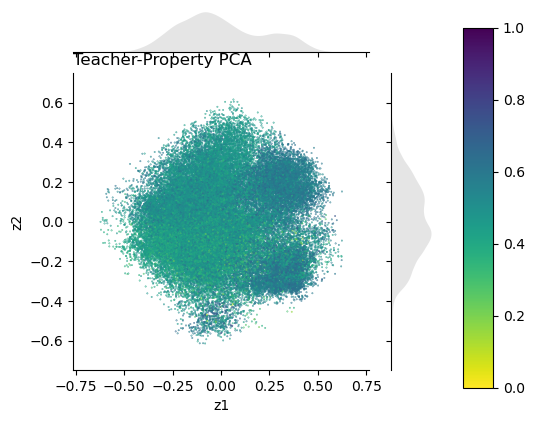

In [449]:
display.Image('teacherproppca.png')

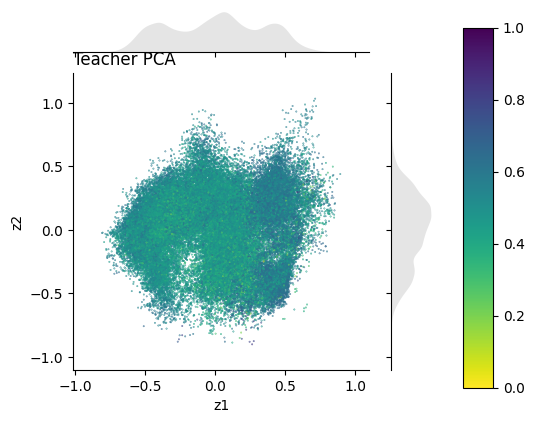

In [450]:
display.Image('teacherpca.png')

In [451]:
perf[['Validation Reconstruction Acc (%)', 'Validation Smile Acc (%)', 'Prior Validity (%)']].iloc[:3]

,Validation Reconstruction Acc (%),Validation Smile Acc (%),Prior Validity (%)
Vanilla,87.0,0.02,0.2
Teacher,88.0,3.30,2.4
Teacher Prop,93.5,17.50,37.4


VAEs are notoriously bad a reconstructing valid smiles... this performance is inline with similar approaches

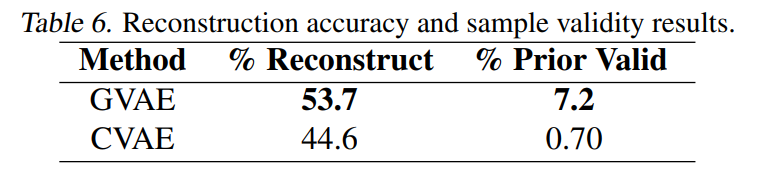

In [452]:
display.Image('typperf.PNG') 

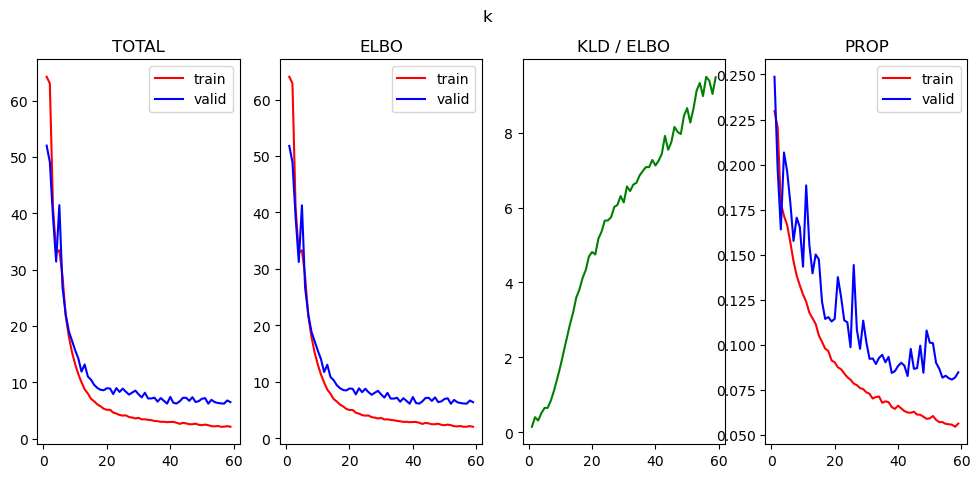

In [453]:
tls, vls = plot_model_performance(tls, vls, name='k')

SELFIES - Self-Referencing Embedded Strings

Tokenizing a smile character by character imposes a vareity of issues and is not really robust

In [454]:
df.molecule_smiles.iloc[30]

'c1ccc(Nc2ccc(-c3ccc(Nc4ccccc4)cc3)cc2)cc1'

Tokenizing in such a way that any string of tokens corresponds to a valid molecule....

Symbol after [branch3] denotes the number of tokens within the branch... information about global properties is encoded locally

In [455]:
sf.encoder(df.molecule_smiles.iloc[30])

'[C][=C][C][=C][Branch2][Ring1][P][N][C][=C][C][=C][Branch2][Ring1][Ring2][C][=C][C][=C][Branch1][#Branch2][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][Ring1][=N][C][=C][Ring2][Ring1][Ring1][C][=C][Ring2][Ring1][#Branch2]'

In [456]:
# Model performance metrics
train_char_acc = [0.879, 0.923, 0.964, 0.93]
valid_char_acc = [0.87, 0.88, 0.935, 0.899]

train_smi_acc = [0.002, 0.129, 0.429, 0.363]
valid_smi_acc = [0.0002, 0.033, 0.175, 0.152]

prior = [0.002, 0.024, 0.374, 0.9997]

columns = ['Train Reconstruction Acc (%)', 'Validation Reconstruction Acc (%)', 'Train Smile Acc (%)', 'Validation Smile Acc (%)', 'Prior Validity (%)']
indexs = ['Vanilla', 'Teacher', 'Teacher Prop', 'Teacher Prop SELFIES']
data = 100 * np.array([train_char_acc, valid_char_acc, train_smi_acc, valid_smi_acc, prior])

In [457]:
perf = pd.DataFrame(data.T, columns=columns, index=indexs)
perf[['Validation Reconstruction Acc (%)', 'Validation Smile Acc (%)', 'Prior Validity (%)']]

,Validation Reconstruction Acc (%),Validation Smile Acc (%),Prior Validity (%)
Vanilla,87.0,0.02,0.20
Teacher,88.0,3.30,2.40
Teacher Prop,93.5,17.50,37.40
Teacher Prop SELFIES,89.9,15.20,99.97


#### Gather metrics

In [ ]:
num_encode_attempts = 10
num_run_throughs = 10
num_decode_attempts = 100

num_mols = 250

train_char_acc, train_smi_acc = reconstruction_accuracy(train_loader, model, num_encode_attempts=num_encode_attempts, num_run_throughs=num_run_throughs, num_decode_attempts=num_decode_attempts, num_mols=num_mols)
valid_char_acc, valid_smi_acc = reconstruction_accuracy(valid_loader, model, num_encode_attempts=num_encode_attempts, num_run_throughs=num_run_throughs, num_decode_attempts=num_decode_attempts, num_mols=num_mols)
prior_acc = prior_validity_accuracy(model, char_list, num_z_samples=1000, num_run_throughs=10, num_decode_attempts=100, eps_std=model.eps_std)
# prior_acc_1 = prior_validity_accuracy(model, char_list, num_z_samples=1000, num_run_throughs=10, num_decode_attempts=100, eps_std=1., selfies=False)

# Visualizing the latent space

In [ ]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
def encode_latent(XX, MODEL):
    with torch.no_grad():
        XX = XX.to(device)

        mu_z, logvar_z = MODEL.encode(XX)
        z = MODEL.reparameterize(mu_z, logvar_z)

    return z

def latent_space_pca(XX, MODEL, n_components=2):
    z = encode_latent(XX, MODEL)
    z_pca = PCA(n_components=n_components).fit_transform(z.cpu())

    return z_pca

In [ ]:
z_pca = latent_space_pca(X_tensor, model)

utility = df.utility_function.copy().values
utility_scaled = (utility - utility.min()) / (utility.max() - utility.min())

zpca_frame = pd.DataFrame(np.hstack([z_pca, utility_scaled[:, None]]), columns=['z1', 'z2', 'u'])

In [ ]:
sample_df = zpca_frame.sample(zpca_frame.shape[0])
g = sns.JointGrid(x=sample_df.z1, y=sample_df.z2, space=0.5)
g.plot_joint(plt.scatter, s=0.1, c=sample_df.u, cmap='viridis_r')
g.plot_marginals(sns.kdeplot, fill=True, alpha=.2, linewidth=0, color='grey')
plt.title('Teacher-Property PCA', loc='left')

plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
cbar_ax = g.figure.add_axes([.85, 0.17, .05, .6])  # x, y, width, height
plt.colorbar(cax=cbar_ax)

# Generating some new molecules

In [58]:
def perturb_z(z, noise_norm, num_samples=1, constant_norm=False):
    assert z.ndim == 1, 'Can only process one latent vector z of shape 1xLATENT_DIM'
    # Generate points that lie uniformly on a sphere centered at z of radius 'AT' or 'UPTO' noise_norm
    # Draw a noise vector from std norm distb. and normalize it
    z = np.tile(z, (num_samples, 1))
    noise_vec = np.random.normal(0, 1, size=z.shape)
    noise_vec /= np.linalg.norm(noise_vec, axis=1)[:, None]
    if constant_norm:
        # at noise_norm std deviations away...
        zprime = z + noise_norm * noise_vec
        return torch.tensor(zprime.astype(np.float32))
    else:
        # upto noise_norm std deviations away (draw multiple norms within the sphere R < noise_norm)
        noise_amp = np.random.uniform(0, noise_norm, size=(z.shape[0], 1))
        zprime = z + noise_norm * noise_vec
        return torch.tensor(zprime.astype(np.float32))

In [458]:
top_batch_size = 10

## Get the top performing molecules by utility
indx = df.utility_function.argsort()[-top_batch_size:].values
df.iloc[indx]

## Or draw random molecules
# indx = np.random.randint(df.shape[0], size=top_batch_size)
# df.iloc[indx]

,molecule_smiles,operation,molecule_last_gen,generation,IP,dGmax,symmetry,added_in_round,calc_status,morgan_fp_bitvect,finished_in_round,utility_function
4348,C1=NCC(C2=NC=NC2)=N1,"[chr5,CH1r5:1]>>[n:1]",C1=CN=C(C2=NC=CC2)C1,4,3.4931,2.394250,True,4,completed,{},5,1.098850
5678,C1=NC(C2=NCC=N2)=NC1,"[chr5,CH1r5:1]>>[n:1]",C1=NC(C2=CCC=N2)=CC1,4,3.4784,2.375141,True,4,completed,{},5,1.103259
55,C1=NN=CC1,"[chr5,CH1r5:1]>>[n:1]",C1=CCC=C1,2,3.6020,2.459150,True,2,completed,{},2,1.142850
16472,C1=NN=CC1=C1N=CC=N1,"[chr5,CH1r5:1]>>[n:1]",C1=CC(=C2N=CC=N2)C=C1,4,3.6219,2.382015,True,4,completed,{},5,1.239885
20233,C1=NC=NC1=C1C=NN=C1,"[chr5,CH1r5:1]>>[n:1]",C1=CC(=C2C=CN=C2)C=N1,5,3.4113,2.148645,True,5,completed,{},5,1.262655
1539,O=C1C=CC(=O)O1,[o:1][ch:2]>>[o:1][c:2](=O),c1ccoc1,3,4.3263,2.968249,True,3,completed,{},3,1.358051
66,O=c1ncocn1,[ch&r6:0]>>[nr6:0],O=c1ccocc1,2,3.3606,1.904838,True,2,completed,{},2,1.455762
278,c1nncs1,[#6H2r5:1]>>[S:1],C1=NN=CC1,3,3.7875,2.216290,True,3,completed,{},3,1.571210
436,c1cnon1,[#6H2r5:1]>>[O:1],C1=NCN=C1,3,4.7921,3.032305,True,3,completed,{},3,1.759795
277,c1nnco1,[#6H2r5:1]>>[O:1],C1=NN=CC1,3,4.4996,1.973368,True,3,completed,{},3,2.526232


In [484]:
# Determine latent representations
X_test = X_tensor[indx]
X_test = X_test.to(device)
original_utilities = df.utility_function.values[indx]

noise = 2.
num_samples = 100
zprimes, xprimes, yprimes = [], [], []

with torch.no_grad():
    mu_z, logvar_z = model.encode(X_test)

    if noise > 0.0:
        pass
        print('Generate sample, then perturbation')
        # Generate representation
        z = model.reparameterize(mu_z, logvar_z)

        # Perturb representation to generate new molecules that are close in latent space
        # and decode them to their associated one-hot-smiles

        for z_test in tqdm(z):
            z_new = perturb_z(z_test, noise, num_samples=num_samples)
            yhat = model.property_predictor(z_new)
            x_new, sample = model.decode(z_new)

            zprimes.append(z_new), xprimes.append(x_new), yprimes.append(yhat)

    else:
        lxs = [[] for _ in range(X_test.shape[0])]
        lzs = [[] for _ in range(X_test.shape[0])]
        lys = [[] for _ in range(X_test.shape[0])]

        print('Generate multiple samples, no perturbation')
        # Generate multiple representation by simply sampling the latent space
        for n in tqdm(range(num_samples)):
            Z = model.reparameterize(mu_z, logvar_z)
            yhat = model.property_predictor(Z)
            X_new, sample = model.decode(Z)

            for xprime, zprime, yprime, lx, lz, ly in zip(X_new, Z, yhat, lxs, lzs, lys):
                lx.append(xprime), lz.append(zprime), ly.append(yprime)

        xprimes = [torch.stack(l) for l in lxs]
        zprimes = [torch.stack(l) for l in lzs]
        yprimes = [torch.stack(l) for l in lys]

Generate sample, then perturbation


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


In [485]:
# How many are valid
valid_smis = []
valid_yhats = []
vfs = []
original_smis = np.array([one_hot_to_smile(x, char_list) for x in X_test])

for xprime, yprime in zip(xprimes, yprimes):
    new_smis = np.array([one_hot_to_smile(x, char_list) for x in xprime])

    # Check smile validity
    valid = np.array([verify_smile(s) for s in new_smis])
    valid_smi = new_smis[valid]
    valid_yhat = yprime[valid]

    valid_smi = [Chem.CanonSmiles(v) for v in valid_smi]
    valid_smi = [v.strip(' ') for v in valid_smi]

    vf = valid.sum() / len(new_smis) # valid fraction

    valid_smis.append(valid_smi)
    valid_yhats.append(valid_yhat)
    vfs.append(vf)

In [486]:
valid_unique_smis = []
valid_unique_yhats = []
non_unique_count = 0
tot_count = 0
dataset_smis = df.molecule_smiles.tolist()

for s_list, yhats in zip(valid_smis, valid_yhats):
    tot_count += len(s_list)
    temps = []
    tempy = []
    for s, yy in zip(s_list, yhats):
        if s not in dataset_smis:
            temps.append(s)
            tempy.append(yy.item())
        else:
            non_unique_count += 1
    
    valid_unique_smis.append(temps)
    valid_unique_yhats.append(tempy)

In [487]:
unique_fraction = 1 - non_unique_count / tot_count
print(f'Fraction of valid smiles: {np.mean(vfs)}')
print(f'Fraction of valid smiles that are unique: {unique_fraction}')

Fraction of valid smiles: 0.4
Fraction of valid smiles that are unique: 0.69


In [488]:
fp_base = [AllChem.GetMorganFingerprint(Chem.MolFromSmiles(s), 2) for s in original_smis]

fp_gens = []
for k in valid_unique_smis:
    fp_gens.append([AllChem.GetMorganFingerprint(Chem.MolFromSmiles(s), 2) for s in k])

# sims_list = BulkTanimotoSimilarity(fp, fp_all)
# indx_sorted_sims = np.flip(np.argsort(sims_list, kind='stable')) # first represents closest

In [489]:
sims = []
for fp, fpg in zip(fp_base, fp_gens):
    sim = BulkTanimotoSimilarity(fp, fpg)
    sims.append(sim)

In [490]:
imgs = []
legends = []
max_imgs = 5
for original, oyyy, generated, s, yyy in zip(original_smis, original_utilities, valid_unique_smis, sims, valid_unique_yhats):
    ms = []
    legend = []
    ms.append(Chem.MolFromSmiles(original))
    legend.append(f'BASE, U: {round(oyyy, 2)}')
    for k, gen in enumerate(generated):
        ms.append(Chem.MolFromSmiles(gen))
        legend.append(f'S: {str(round(s[k], 2))}, U: {str(round(yyy[k], 2))}')
        if k == max_imgs-1:
            break
    
    img = Chem.Draw.MolsToGridImage(ms, molsPerRow=3, subImgSize=(250,250), legends=legend)
    imgs.append(img)
    legends.append(legend)

Uniquely Generated Molecules, their similarity to the base molecule, and predicted utility
CANDIDATE 0


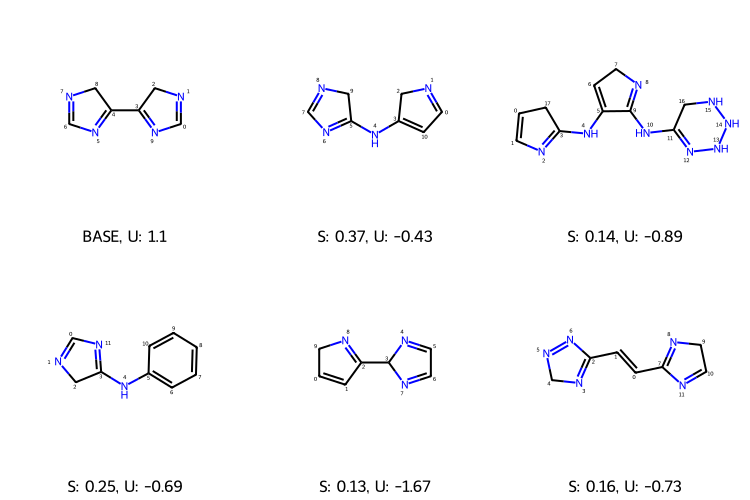

CANDIDATE 1


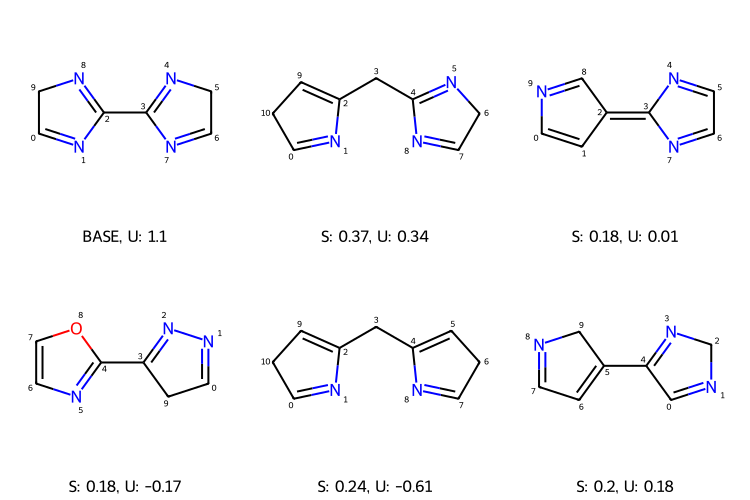

CANDIDATE 2


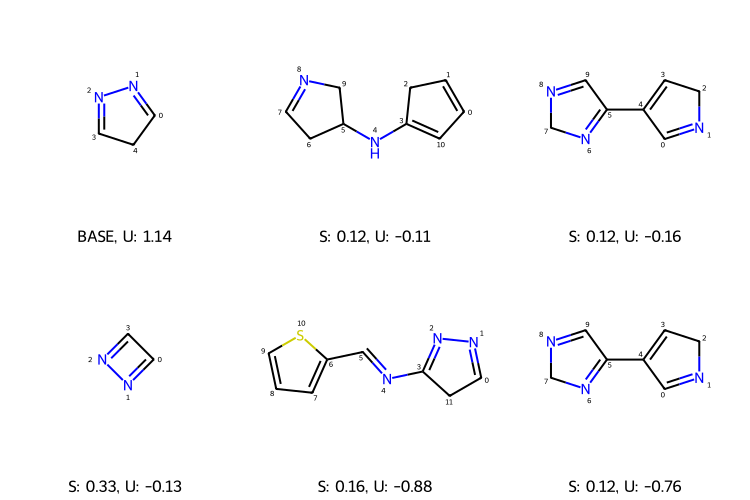

CANDIDATE 3


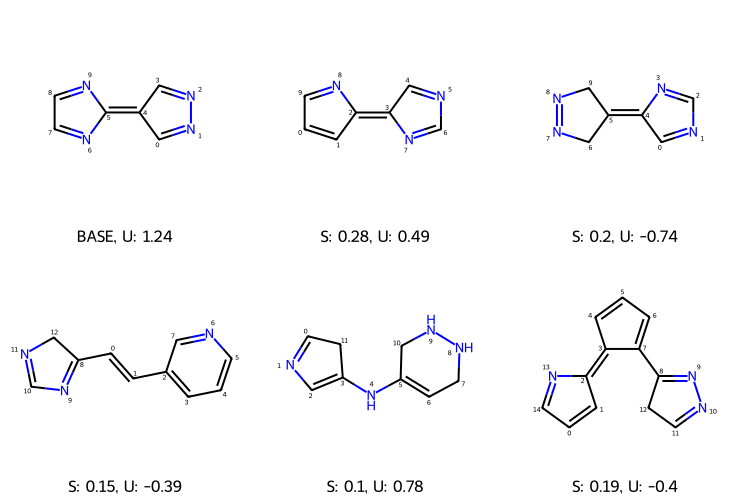

CANDIDATE 4


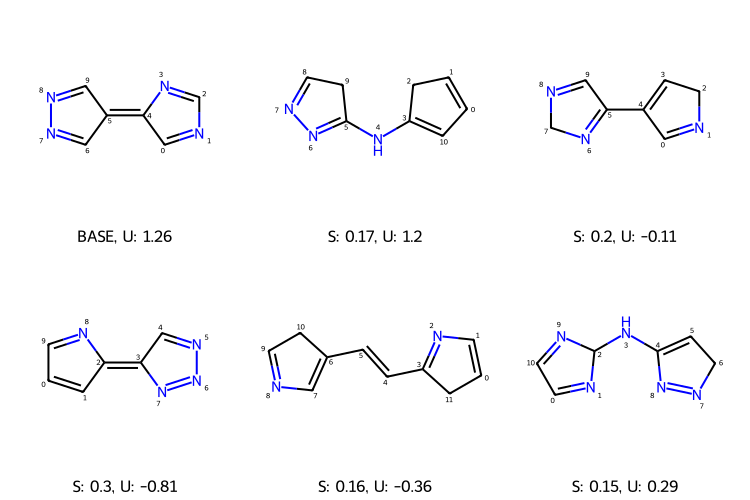

CANDIDATE 5


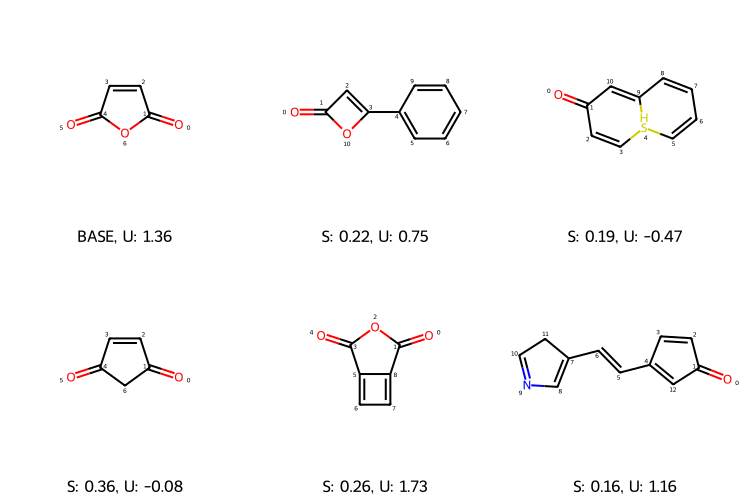

CANDIDATE 6


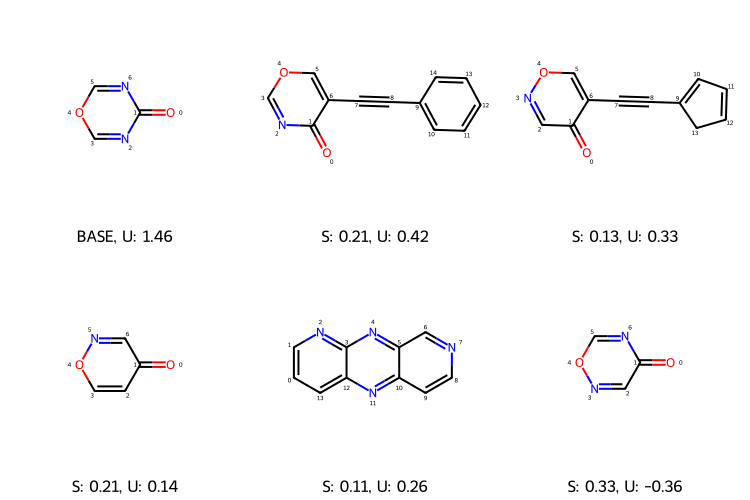

CANDIDATE 7


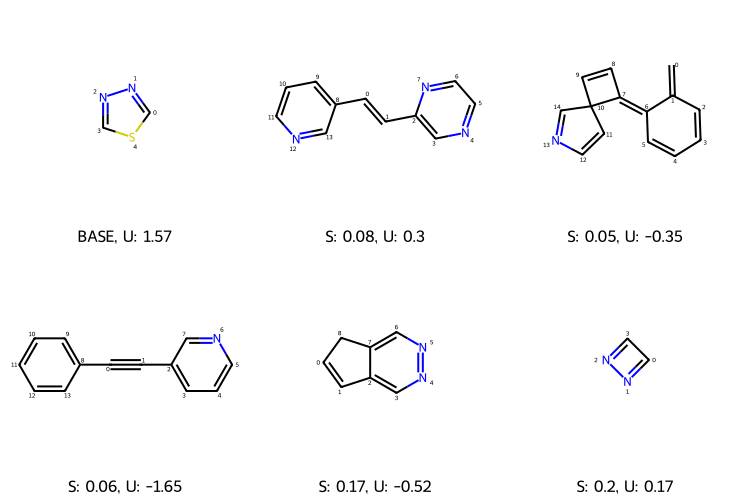

CANDIDATE 8


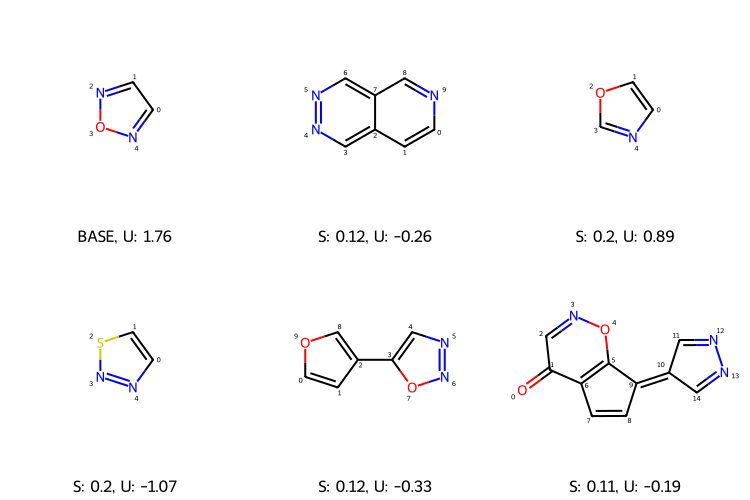

CANDIDATE 9


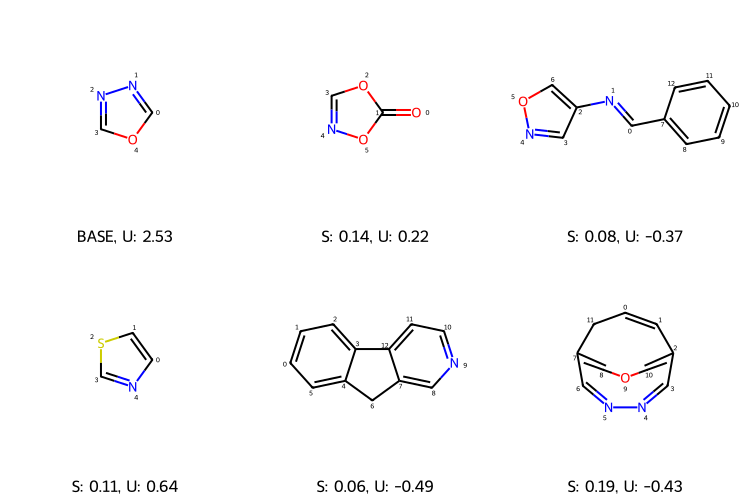

In [491]:
print('Uniquely Generated Molecules, their similarity to the base molecule, and predicted utility')

for j, i in enumerate(imgs):
    print(f'CANDIDATE {j}')
    dp(i)

#### Still need to verify predicted utility with what would actually be simulated!

#### 250 high performing base mols and their mean generated utility (noise=0.)

In [ ]:
mean_utilities = [np.mean(v) for v in valid_unique_yhats]

plt.scatter(original_utilities, mean_utilities, color='blue', alpha=0.5)
plt.plot(original_utilities, original_utilities, color='k')
plt.ylabel('Mean Generated Utility')
plt.xlabel('Original Utility')
plt.title('Sampling z-space for new high utility molecules (noise=1.)')

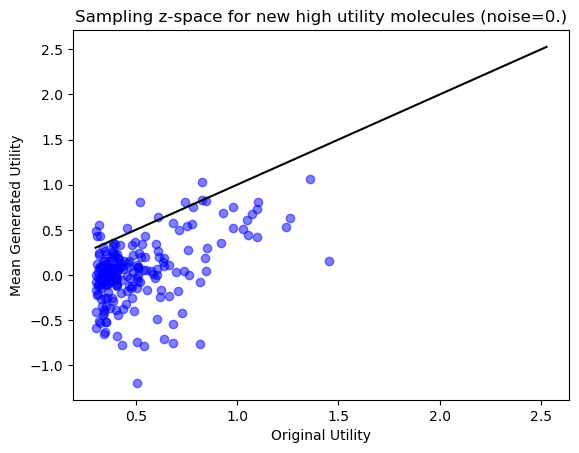

In [483]:
display.Image('genutilvsutil0.png')

# Interpolation

In [340]:
num_decode_attempts = 100
num_interp_mols = 20 # Must be in powers of 10

indxs_ = np.random.randint(X_tensor.shape[0], size=2)
orig_smis = df.molecule_smiles.iloc[indxs_].values
X_2 = X_tensor[indxs_] #2 random molecules to interpolate between
alpha = torch.linspace(0, 1, num_interp_mols) #degree of interpolation

In [341]:
d = {a : None for a in range(len(alpha))}
alive = {a : None for a in range(len(alpha))}

alive[0] = True
alive[num_interp_mols-1] = True

d[0] = orig_smis[0]
d[num_interp_mols-1] = orig_smis[-1]

In [342]:
valid_smi_list = alpha.shape[0] * [None]
already_found = orig_smis.copy().tolist()

with torch.no_grad():
    X_2 = X_2.to(device)
    mu_z, logvar_z = model.encode(X_2)

    for i in tqdm(range(num_decode_attempts)):
        z = model.reparameterize(mu_z, logvar_z)
        z_interps = torch.stack([(1-a) * z[0] + a * z[1] for a in alpha]) #linearly interpolated zs
        Xhat, sample = model.decode(z_interps)

        # Check for valid decodings
        smis_hat = [one_hot_to_smile(xhat, char_list).strip(' ') for xhat in Xhat]

        for j, s in enumerate(smis_hat):
            if (j == 0) or (j == (num_interp_mols-1)):
                continue
            
            if verify_smile(s):
                alive[j] = True
                
                if s not in already_found:
                    d[j] = s
                    already_found.append(s)

        if np.count_nonzero(np.array(list(d.values())) == None) == 0:
            # Break if we've populated dict 'd' with unique valid smiles already
            break

  0%|          | 0/100 [00:00<?, ?it/s]

 71%|███████   | 71/100 [00:32<00:13,  2.21it/s]


In [343]:
ms = [Chem.MolFromSmiles(s) if s is not None else Chem.MolFromSmiles('I') for s in d.values()]

In [346]:
# legends = [f'alpha: {alp:.2f}, alive: {aliv}' for alp, aliv in zip(alpha, alive.values())]
legends = [f'alpha: {alp:.2f}' for alp, aliv in zip(alpha, alive.values())]

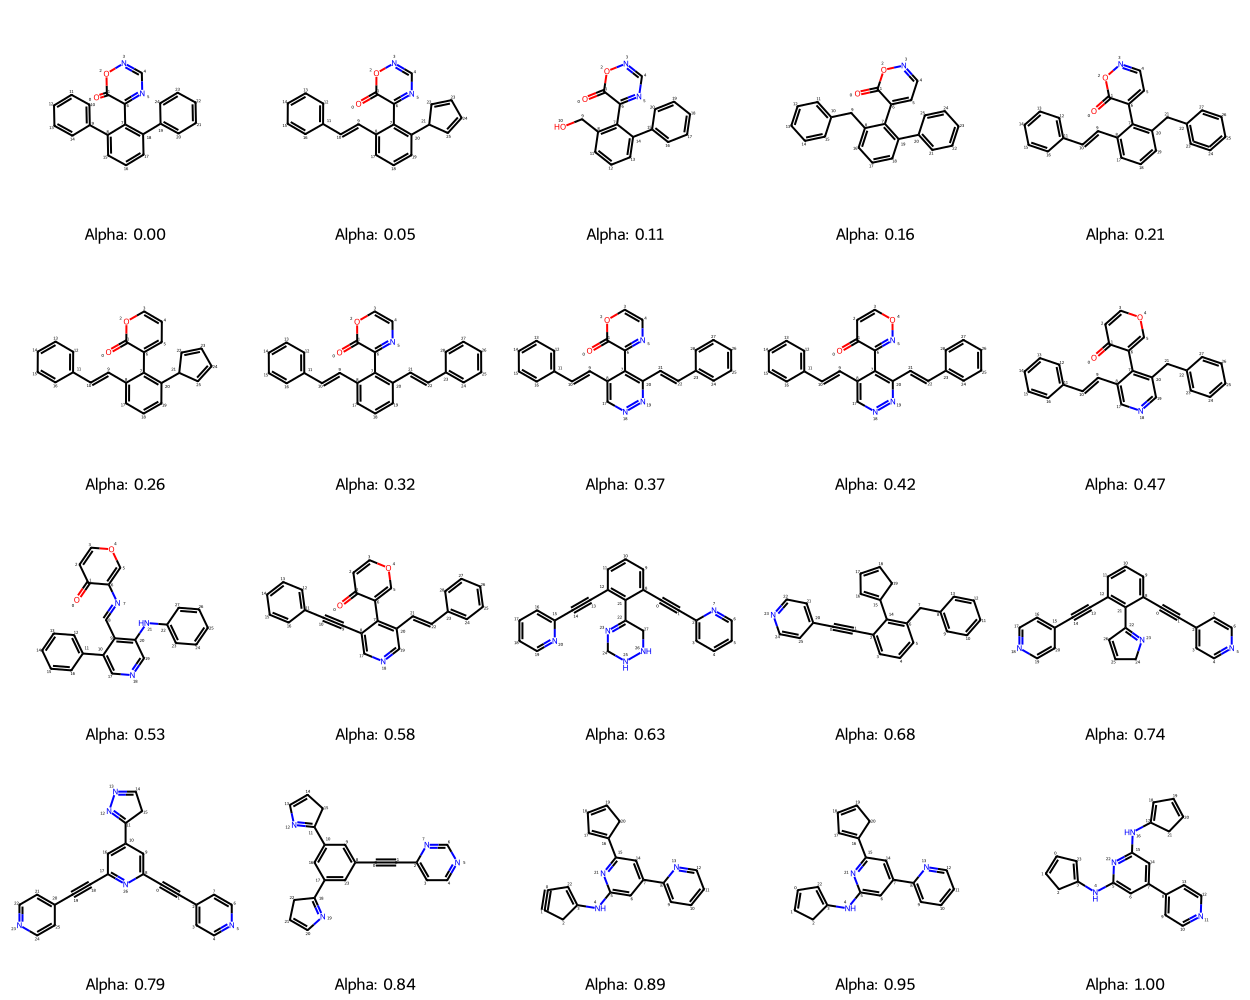

In [347]:
Chem.Draw.MolsToGridImage(ms, subImgSize=(250,250), molsPerRow=5, legends=legends)

# Gradient-Based Bayesian Optimization

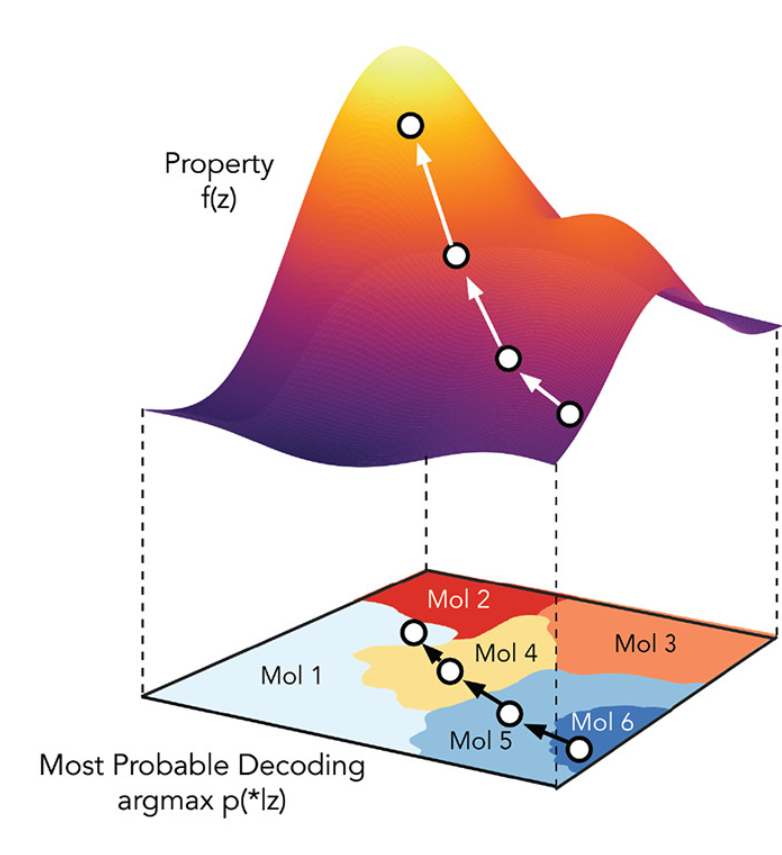

In [413]:
display.Image('propmax.PNG', width=500, height=100)

### Pseudocode

1. Pick ~5000 representative or random samples from the dataset
2. Encode them to their continuous latent representations Z
3. Each latent vector has an associated known utility
4. Train a model that predicts utility from Z (utility = F(Z))

5. Initialize Z0 (potentially multiple of them) and perform gradient descent to find zmax, Umax (or rather maximize an acqusition function)
6. This gives us the most likely location to find a maximum according to the predictive model.

7. Evaluate the true utility using expensive simulation.... Utrue = SIMULATION(zmax)

8. Add new-found samples to the initial dataset... retrain the model thereby updating its prior, and repeat optimizations...

### Problems with NN's as property predictors for BO

1. The jointly trained property-prediction NN, despite being good, is rather expensive to train

2. Optimizing the property-predictor requires a lot of NN evaluations... also expensive

3. Its also not as 'smooth' as we'd like it to be, which results in a bunch noisy predictions, which thus requires more simulations to be performed... expensive

# Bayesian Optimization with GPR's

So rather, train a light-weight GPR over the latent vectors, thats cheap to train and subsequently predict with, and its much smoother!

In [ ]:
for i in range(n_bo_iter):
    print('###############################')
    print(f'Bayesian Optimization iter {i}')
    
    # Update Gaussian process with existing samples
    print('\nFitting Surrogate Model')

    gpr.fit(Z_sampled, Y_sampled)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    Z_candidates, neg_acqu_candidates = propose_location(expected_improvement, Y_sampled, gpr, bounds, n_restarts=n_restarts)
    
    # Decode and evaluate smiles for their utility
    Z_candidate = Z_candidates[np.argmin(neg_acqu_candidates)]

    # Try decoding the best candidate and evaluate
    out = evaluate_latent(Z_candidate, calc_params=calc_params, num_run_throughs=num_run_throughs, num_decode_attempts=num_decode_attempts, iter_fname=i, return_all_info=True)
    
    if out is not None:
        s, ip, rdg = out
    else:
        # Skip below and try another iteration
        continue
    
    Y_candidate = ip - rdg
    fresh_evaluated_smiles.append((s, ip, rdg))

    # Add sample to previous samples
    Z_sampled = np.vstack((Z_sampled, Z_candidate))
    Y_sampled = np.vstack((Y_sampled, Y_candidate))

# TODO

1. SELFIES
2. Hyperparameter Optimization?
3. BO run

----

# Bayesian Optimization

## with skopt
(allows for parallelization of acqu func minimization)

In [ ]:
from skopt import Optimizer

In [ ]:
from skopt import gp_minimize
from photocatalysis.evaluate import evaluate_substrate

In [ ]:
def evaluate_latent_wrapper(z0):
    # minimize the negative utility
    global bo_current_iter
    print('###############################')
    print(f'Bayesian Optimization iter {bo_current_iter}')

    z0 = np.array(z0).reshape(1, -1)
    U = evaluate_latent(z0, calc_params=calc_params, num_run_throughs=num_run_throughs, num_decode_attempts=num_run_throughs, iter_fname=bo_current_iter, return_all_info=False)
    bo_current_iter += 1
    return -U

In [ ]:
global bo_current_iter
bo_current_iter = 0

In [ ]:
n_bo_iter = 25 # number of function evaluations used to update GPR surrogate prior
n_init = 2000 # number of initial representations to train the surrogate model
n_restarts = 25 # number of starting points for acqu func minization

num_run_throughs = 100
num_decode_attempts = 100
calc_params = {'gfn':2, 'acc':0.2, 'etemp':298.15, 'gbsa':'water'}
MP_CORES_AVAILABLE = 22

run_dir = '/home/btpq/bt308495/Thesis/run/BO_skopt'

if not os.path.isdir(run_dir):
    os.mkdir(run_dir)
    
os.chdir(run_dir)

In [ ]:
# Encode molecule set
z = encode_latent(X_tensor, model)

# Select initial data points to start optimization
ri = np.random.randint(z.shape[0], size=n_init)
Z_sampled, Y_sampled = z[ri].numpy(), y[ri]

# Sequence of min-max pairs for each latent dim
bounds = np.vstack([z.numpy().min(axis=0), z.numpy().max(axis=0)]).T

In [ ]:
optimizer = Optimizer(dimensions, base_estimator='GP',
                          n_initial_points=n_initial_points,
                          initial_point_generator=initial_point_generator,
                          n_jobs=n_jobs,
                          acq_func=acq_func, acq_optimizer=acq_optimizer,
                          random_state=random_state,
                          model_queue_size=model_queue_size,
                          acq_optimizer_kwargs=acq_optimizer_kwargs,
                          acq_func_kwargs=acq_func_kwargs)

In [ ]:
res = gp_minimize(evaluate_latent_wrapper,
                  bounds,
                  n_calls=n_bo_iter,
                  acq_func="EI",
                  n_restarts_optimizer=n_restarts,
                  acq_optimizer='lbfgs',
                  n_jobs=12,
                  random_state=42,
                  x0=Z_sampled.tolist(),
                  y0=Y_sampled[:, 0].tolist(),
                  verbose=True) 

In [ ]:
res

## Manually

In [ ]:
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn import gaussian_process as gp

In [ ]:
def expected_improvement(X, Y_sampled, surrogate_model, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        Y_sample: Sample values (n x 1).
        surrogate_model: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    Y, sigma = surrogate_model.predict(X, return_std=True)
    sigma = sigma.reshape(-1, 1)
    
    best_sampled_Y = np.max(Y_sampled)

    with np.errstate(divide='warn'):
        # EI equation.... where Y (predictions) represents the mean of the surrogate gpr model, and sigma represents the std/uncertainty estimate of the prediction
        imp = Y - best_sampled_Y - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [ ]:
def propose_location(acquisition_function, Y_sampled, surrogate_model, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function over the surrogate model.
    In practice, optimizing this function is much cheaper than directly optimizing an expensive black-box function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        surrogate_model: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = surrogate_model.n_features_in_
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition_function(X.reshape(-1, dim), Y_sampled, surrogate_model)
    
    # Find the best optimum by starting from n_restart different random points.
    print(f'Optimizing Acquisition Function: {acquisition_function.__name__} w/ {n_restarts} restarts')

    mins_x, mins_val = [], []
    start_locations = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim))
    for x0 in tqdm(start_locations):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B') 

        # Log each opt result to have multiple latent vectors to choose from,
        # incase the min_val latent vector decodes to garbage
        min_val = res.fun
        min_x = res.x.reshape(1,-1)

        mins_x.append(min_x)
        mins_val.append(min_val)

        # if res.fun < min_val:
        #     # If choosing the best optimization
        #     min_val = res.fun
        #     min_x = res.x

    print(f'Best Expected Improvement in Utility: {min(mins_val)}')           
            
    return np.array(mins_x), np.array(mins_val)

In [ ]:
def decode_logits(Logits, character_list, num_decode_attempts=100):
    # Probabilistic multinomial sampling of softmax output logist
    # and subsequent bare smile string decoding w/o validation
    assert Logits.shape[1] == character_list.size, 'Logit length doesnt match character_set length'
    decoded_smiles = []

    for _ in range(num_decode_attempts):
        indx = torch.multinomial(Logits, 1)
        one_hot = torch.zeros_like(Logits)
        one_hot.scatter_(1, indx, 1)
        
        smile = one_hot_to_smile(one_hot, character_list)
        decoded_smiles.append(smile)
    
    return decoded_smiles

def find_valid_smiles_from_logits(logits_batch, character_list, num_decode_attempts=100):
    # Look through logits batch, decode probabilistically, and return a list of valid smile strings

    valid_smiles = []
    for l in logits_batch:
        smiles = decode_logits(l, character_list, num_decode_attempts=num_decode_attempts)

        for s in smiles:
            if verify_smile(s):
                valid_smiles.append(s)

    return valid_smiles

In [ ]:
def run_evaluation(smile, CALC_PARAMS, scratch_dir=None):
    base = os.getcwd()

    if scratch_dir is not None:
        os.mkdir(scratch_dir)

    try:
        # ip, rdg, asites, rds, essi = output
        output = evaluate_substrate(smile, CALC_PARAMS, scratch_dir=scratch_dir, relax_mp=MP_CORES_AVAILABLE) # scratch_dir=SCRATCH_DIR)
        print('Success!')
        return output, None
    
    except Exception as e:
        output = None

        print('Error Encountered!')
        print(e)
        os.system('echo "{}" >> errors.txt'.format(e))
        os.chdir(base)
        return output, e
    
def evaluate_latent(z, calc_params=None, num_run_throughs=10, num_decode_attempts=100, iter_fname=0, return_all_info=True, error_thresh_count=10):
    # Given a latent vector, return its valid smile and associated utility
    
    # The VAE is probabilistic in decoding (i.e. a softmax is sampled to determine which character is fed next into the RNN-decoder)
    # and probabilistic in sampling the output (i.e. the output logits define a probability distb. over the possible characters,
    # and multiple smiles can be sampled)

    # So we can sample multiple model calls (num_run_throughs) and multiple smiles from the resulting logits (num_decode_attempts)

    trials = num_run_throughs*num_decode_attempts
    z = torch.from_numpy(z.astype(np.float32))
    z_repeat = z.repeat(num_run_throughs, 1)

    logits_batch, _ = model.decode(z_repeat)

    print('Decoding latent representation into valid smiles')
    smiles = find_valid_smiles_from_logits(logits_batch, char_list, num_decode_attempts=num_decode_attempts)

    # print('Premature Breaking before simulation/evaluation')
    # return smiles

    if smiles:
        print('Success!')
        print(f'Found {len(smiles)} / {trials} valid smiles')
        # atleast one valid smile exists
        # evaluate until first successful evaluation occurs and return results
        error_count = 0
        for j, smile in enumerate(smiles):
            print(f'Evaluating candidate {j}')
            print('--------------------')

            smile = smile.strip(' ') # remove any trailing whitespaces
            output, error = run_evaluation(smile, calc_params, scratch_dir=f'eval{iter_fname}_{j}')

            if output is not None:
                ip, rdg, _, _, _ = output
                os.system('echo "{} {} {}" >> results.txt'.format(smile, ip, rdg))

                if return_all_info:
                    return (smile, ip, rdg)
                else:
                    util = ip - rdg
                    return util
            
            error_count += 1

            if error_count > error_thresh_count-1:        
                # No Succesful run
                print('No Successful evaluation :(')
                return None
    else:
        # No valid smiles
        print('Fail!')
        return None

In [ ]:
n_bo_iter = 50 # number of function evaluations used to update GPR surrogate prior
n_init = 5000 # number of initial representations to train the surrogate model
n_restarts = 25 # number of starting points for acqu func minization

num_run_throughs = 50
num_decode_attempts = 50
calc_params = {'gfn':2, 'acc':0.2, 'etemp':298.15, 'gbsa':'water'}
MP_CORES_AVAILABLE = 22

run_dir = '/home/btpq/bt308495/Thesis/run/BO_test_test'

if not os.path.isdir(run_dir):
    os.mkdir(run_dir)
    
os.chdir(run_dir)

In [ ]:
# Encode molecule set
z = encode_latent(X_tensor, model)

# Select initial data points to start optimization
ri = np.random.randint(z.shape[0], size=n_init)
Z_sampled, Y_sampled = z[ri].numpy(), y[ri]

# Sequence of min-max pairs for each latent dim
bounds = np.vstack([z.numpy().min(axis=0), z.numpy().max(axis=0)]).T

Bayesian Optimization Run

In [ ]:
gpr = gp.GaussianProcessRegressor(alpha=1e-5,
                                  n_restarts_optimizer=10,
                                  normalize_y=True,
                                  random_state=42)

fresh_evaluated_smiles = [] # saving newly created smiles and their associated properties

In [ ]:
for i in range(n_bo_iter):
    print('###############################')
    print(f'Bayesian Optimization iter {i}')
    
    # Update Gaussian process with existing samples
    print('\nFitting Surrogate Model')
    gpr.fit(Z_sampled, Y_sampled)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    Z_candidates, neg_acqu_candidates = propose_location(expected_improvement, Y_sampled, gpr, bounds, n_restarts=n_restarts)
    
    # Decode and evaluate smiles for their utility
    Z_candidate = Z_candidates[np.argmin(neg_acqu_candidates)]

    # Try decoding the best candidate and evaluate
    out = evaluate_latent(Z_candidate, calc_params=calc_params, num_run_throughs=num_run_throughs, num_decode_attempts=num_decode_attempts, iter_fname=i, return_all_info=True)
    
    if out is not None:
        s, ip, rdg = out
    else:
        # Skip below and try another iteration
        continue
    
    Y_candidate = ip - rdg
    fresh_evaluated_smiles.append((s, ip, rdg))

    # Add sample to previous samples
    Z_sampled = np.vstack((Z_sampled, Z_candidate))
    Y_sampled = np.vstack((Y_sampled, Y_candidate))

Gets multiple optimization results incase smiles decoding fails....

In [ ]:
# for i in range(n_bo_iter):
#     print('###############################')
#     print(f'Bayesian Optimization iter {i}')
    
#     # Update Gaussian process with existing samples
#     print('\nFitting Surrogate Model')
#     gpr.fit(Z_sampled, Y_sampled)

#     # Obtain next sampling point from the acquisition function (expected_improvement)
#     Z_candidates, neg_acqu_candidates = propose_location(expected_improvement, Y_sampled, gpr, bounds, n_restarts=n_restarts)
    
#     # Decode and evaluate smiles for their utility
#     Z_candidates_sorted = Z_candidates[np.argsort(neg_acqu_candidates, kind='stable')]
#     for j, Z_candidate in enumerate(Z_candidates_sorted):
#         # Try decoding the best candidate
#         output = evaluate_latent(Z_candidate, calc_params=calc_params, num_run_throughs=num_run_throughs, num_decode_attempts=num_decode_attempts, iter_fname=i)
        
#         if output is not None:
#             s, o = output
#             ip, rdg, _, _, _ = o
#             Y_candidate = ip - rdg
#             fresh_evaluated_smiles.append((s, ip, rdg))
#             print('Candidate:', s)
#             print('Utility:', Y_candidate)
#             break

#         else:
#             # Try next best candidate
#             print('Attempting to decode/evaluate next best candidate')
#             continue
    
#     if len(fresh_evaluated_smiles)-1 != i:
#         raise ValueError(f'Non Successful smiles evaluated in BO iter {i}')
    
#     # Add sample to previous samples
#     Z_sampled = np.vstack((Z_sampled, Z_candidate))
#     Y_sampled = np.vstack((Y_sampled, Y_candidate))

In [ ]:
bo_smiles = np.array([Chem.CanonSmiles(s) for s, _, _ in fresh_evaluated_smiles])

In [ ]:
for j, s in enumerate(bo_smiles):
    if s in df.molecule_smiles:
        print('Duplicate Found')
        print(j, s)

In [ ]:
bo_utilites = Y_sampled[n_init:]

In [ ]:
sorted_util_indx = bo_utilites.flatten().argsort(axis=0)

for k, m in zip(bo_utilites[sorted_util_indx], bo_smiles[sorted_util_indx]):
    print(k, m)

In [ ]:
test_smile = bo_smiles[sorted_util_indx][-2]
u_test = bo_utilites[sorted_util_indx][-2][0]

In [ ]:
fp = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(test_smile), 2)
fp_all = [AllChem.GetMorganFingerprint(Chem.MolFromSmiles(s), 2) for s in df.molecule_smiles]

sims_list = BulkTanimotoSimilarity(fp, fp_all)
indx_sorted_sims = np.flip(np.argsort(sims_list, kind='stable')) # first represents closest

In [ ]:
num_closest = 24 # get closest mols in tanimoto similarity
closest_smiles_indx = indx_sorted_sims[:num_closest]
sim_smiles = df.molecule_smiles.iloc[closest_smiles_indx].tolist()
sim_smiles_utility = df.utility_function.iloc[closest_smiles_indx].tolist()

tot_smiles = [test_smile] + sim_smiles

In [ ]:
legend = [str(round(u_test, 3))] + [str(round(u, 3)) for u in sim_smiles_utility]
img = Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in tot_smiles], molsPerRow=3, legends=legend)
img

In [ ]:
plt.plot(bo_utilites)